<a href="https://colab.research.google.com/github/arsyadCode/TuRu-ML_CC/blob/main/ASL%20Trial2%20with%20RGB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting Up Kaggle

In [9]:
! pip install -q kaggle

In [10]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kmarsyad","key":"0b2fab08fb1915b97629ea87647e49a5"}'}

In [11]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [12]:
! chmod 600 ~/.kaggle/kaggle.json

In [13]:
! kaggle datasets download -d mrgeislinger/asl-rgb-depth-fingerspelling-spelling-it-out

100% 2.10G/2.11G [00:20<00:00, 69.7MB/s]
100% 2.11G/2.11G [00:20<00:00, 108MB/s] 


In [38]:
! kaggle datasets download -d keras/vgg19

 99% 576M/580M [00:06<00:00, 108MB/s] 
100% 580M/580M [00:06<00:00, 96.4MB/s]


In [14]:
! unzip /content/fingerspelling.zip -d /input

Streaming output truncated to the last 5000 lines.
  inflating: /input/dataset5/E/u/color_20_0231.png  
  inflating: /input/dataset5/E/u/color_20_0232.png  
  inflating: /input/dataset5/E/u/color_20_0233.png  
  inflating: /input/dataset5/E/u/color_20_0234.png  
  inflating: /input/dataset5/E/u/color_20_0235.png  
  inflating: /input/dataset5/E/u/color_20_0236.png  
  inflating: /input/dataset5/E/u/color_20_0237.png  
  inflating: /input/dataset5/E/u/color_20_0238.png  
  inflating: /input/dataset5/E/u/color_20_0239.png  
  inflating: /input/dataset5/E/u/color_20_0240.png  
  inflating: /input/dataset5/E/u/color_20_0241.png  
  inflating: /input/dataset5/E/u/color_20_0242.png  
  inflating: /input/dataset5/E/u/color_20_0243.png  
  inflating: /input/dataset5/E/u/color_20_0244.png  
  inflating: /input/dataset5/E/u/color_20_0245.png  
  inflating: /input/dataset5/E/u/color_20_0246.png  
  inflating: /input/dataset5/E/u/color_20_0247.png  
  inflating: /input/dataset5/E/u/color_20_0248.p

In [39]:
! unzip /content/vgg19.zip -d /input

Archive:  /content/vgg19.zip
  inflating: /input/imagenet_class_index.json  
  inflating: /input/vgg19_weights_tf_dim_ordering_tf_kernels.h5  
  inflating: /input/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5  


# Import Environments

In [15]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
# os.mkdir("../input")
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['dataset5']


### Define function to store labels and images into a dictionary

In [16]:
import glob

def get_labels_images(filepath):
    data_dict = {}
    for directory in glob.glob(filepath):
        images = []
        for file in glob.glob(directory+'/color_*.png'):
            images.append(file)
        data_dict.setdefault(directory[-1], images)
        
    return data_dict

In [17]:
dataset_dir = os.path.abspath('../input/dataset5/*/*')
data_dict = get_labels_images(dataset_dir)

### Display some images for sanity

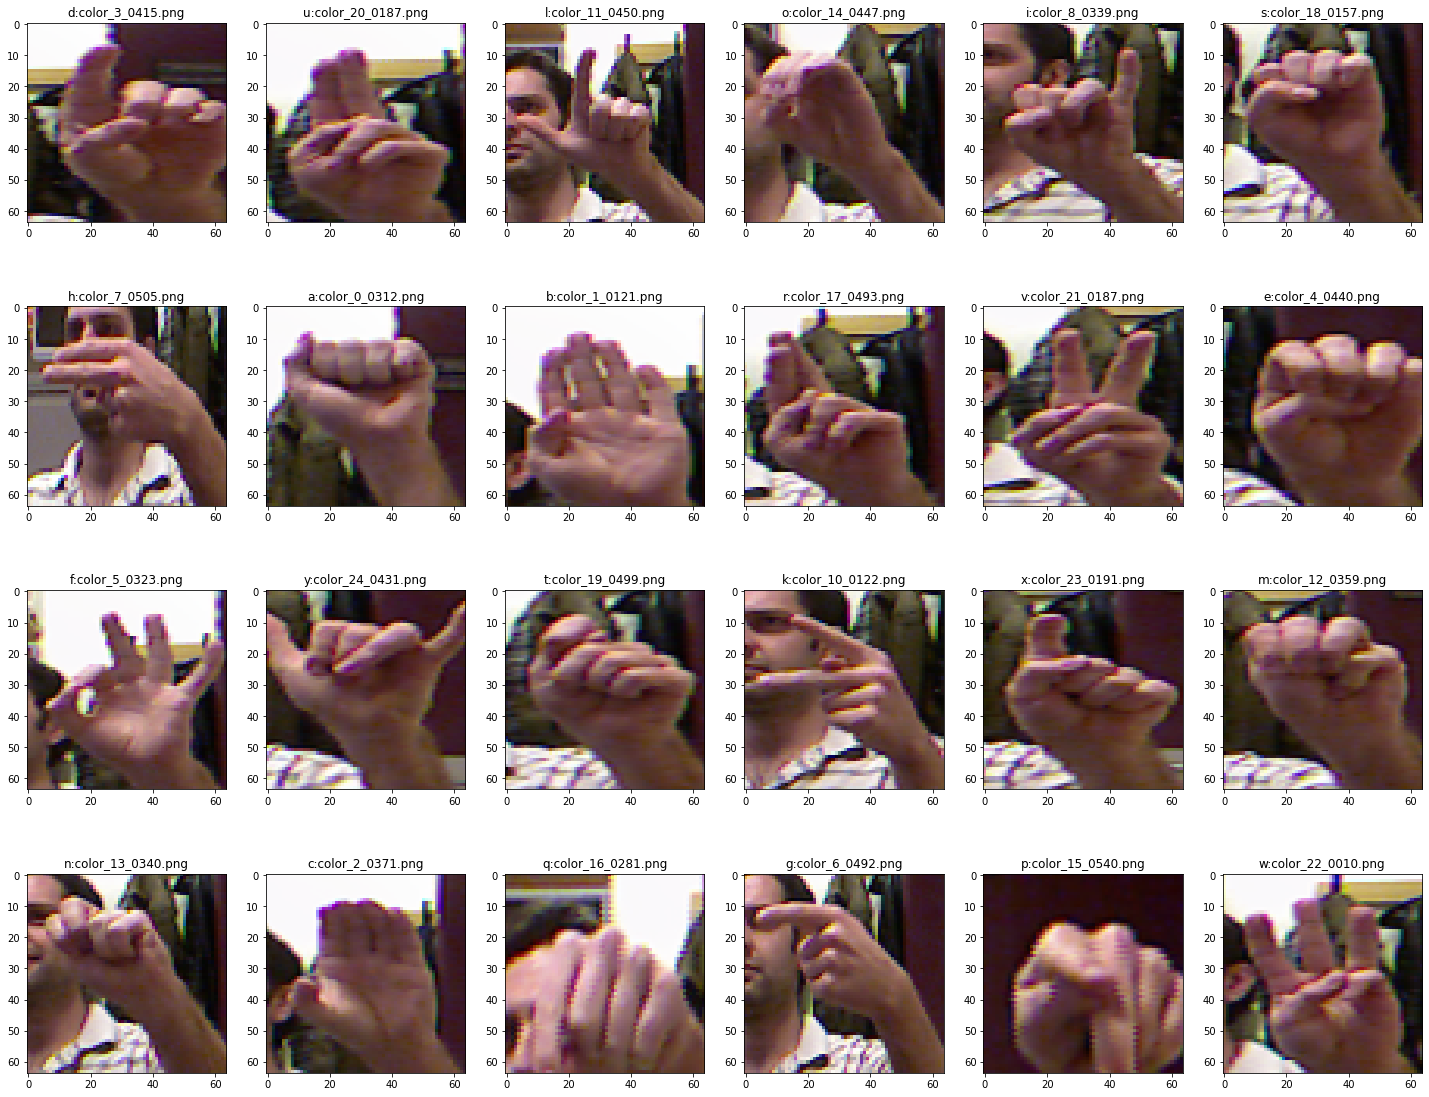

In [18]:
import cv2
import matplotlib.pyplot as plt

plt.figure(figsize = (25,20))

for i, (k,v) in enumerate(data_dict.items()):
    img = cv2.imread(v[0])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (64,64))
    plt.subplot(4,6,i+1)
    plt.imshow(img)
    plt.title(k + ":" + os.path.basename(v[0]))
    
plt.show()

### Define function to preprocess images

In [56]:
def preprocess_images(dictionary, height = 32, width = 32):
    images = []
    labels = []
    for k,v in dictionary.items():
        for file in v:
            img = cv2.imread(file)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  #channel
            img = cv2.resize(img, (height, width))  #size
            img = img / 255.  #normalize
            images.append(img)
            labels.append(k)
    
    return (np.array(images), np.array(labels).reshape(-1,1))

images, labels = preprocess_images(data_dict)

### Encode our labels

In [20]:
from sklearn.preprocessing import LabelBinarizer

lbl_binarizer = LabelBinarizer()
labels = lbl_binarizer.fit_transform(labels)

### Define function to create train, dev, test split

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(images, labels, test_size = 0.2, random_state = 1)
X_train, X_dev, Y_train, Y_dev = train_test_split(X_train, Y_train, test_size = 0.25, random_state = 1)

print('Number of training samples:{}, Shape: {}'.format(len(X_train), X_train.shape))
print('Number of dev samples:{}, Shape: {}'.format(len(X_dev), X_dev.shape))
print('Number of test samples:{}, Shape: {}'.format(len(X_test), X_test.shape))

Number of training samples:7527, Shape: (7527, 28, 28, 3)
Number of dev samples:2510, Shape: (2510, 28, 28, 3)
Number of test samples:2510, Shape: (2510, 28, 28, 3)


### Display some images for sanity

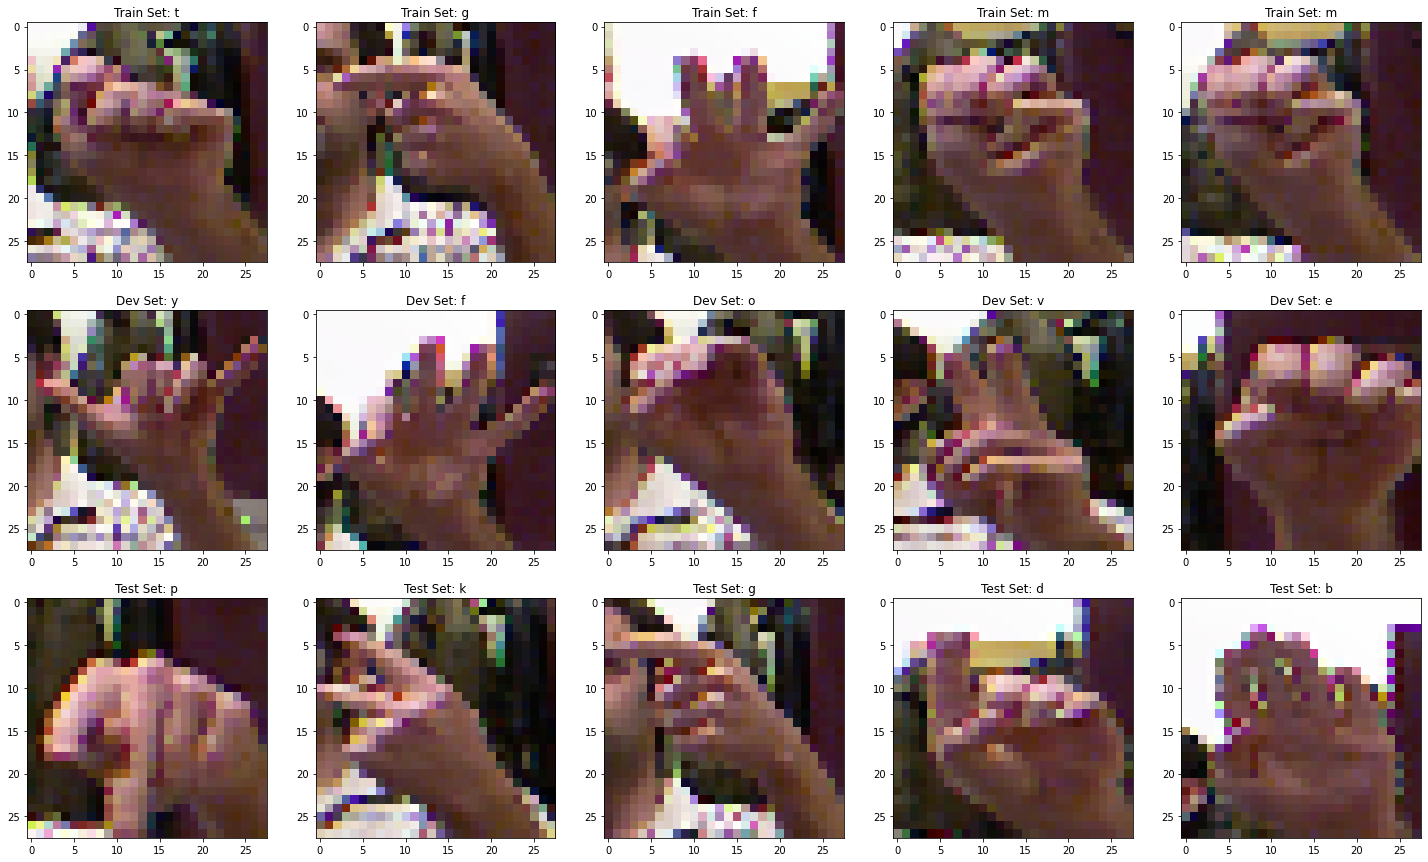

In [23]:
plt.figure(figsize = (25,15))

for i in range(5):
    plt.subplot(3,5,i+1)
    plt.imshow(X_train[i])
    plt.title('Train Set: {}'.format(lbl_binarizer.classes_[np.argmax(Y_train[i], axis = -1)]))

for i in range(5,10):
    plt.subplot(3,5,i+1)
    plt.imshow(X_dev[i])
    plt.title('Dev Set: {}'.format(lbl_binarizer.classes_[np.argmax(Y_dev[i], axis = -1)]))

for i in range(10,15):
    plt.subplot(3,5,i+1)
    plt.imshow(X_test[i])
    plt.title('Test Set: {}'.format(lbl_binarizer.classes_[np.argmax(Y_test[i], axis = -1)]))

plt.show()

### Build our model

In [54]:
from tensorflow import keras
from keras import optimizers
from keras.applications.vgg19 import VGG19

optimizer=keras.optimizers.RMSprop(learning_rate=0.01)

img_height = 64
img_width = 64
img_channels = 3
num_classes = labels.shape[1]
learning_rate = 1e-5
weights = '../input/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'

def build_model():
    base = VGG19(include_top = False, weights = weights, input_shape = (img_height, img_width, img_channels))
    X = base.output
    X = keras.layers.Flatten()(X)
    X = keras.layers.Dense(512, activation = 'relu')(X)
    X = keras.layers.Dropout(0.4)(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.Dense(512, activation = 'relu')(X)
    X = keras.layers.Dropout(0.3)(X)
    X = keras.layers.BatchNormalization()(X)
    preds = keras.layers.Dense(num_classes, activation = 'softmax')(X)
    
    model = keras.models.Model(inputs = base.input, outputs = preds)
    model.compile(optimizer = keras.optimizers.RMSprop(lr = learning_rate), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model

In [55]:
model = build_model()
model.summary()

ValueError: ignored

### Define our callbacks and train our model

In [53]:
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience = 5, verbose = 0, restore_best_weights = True)]

history = model.fit(X_train, Y_train,
                    epochs = 25,
                    batch_size = 128,
                    validation_data = (X_dev, Y_dev),
                    callbacks = callbacks)

Epoch 1/25


ValueError: ignored

### Plot our metrics

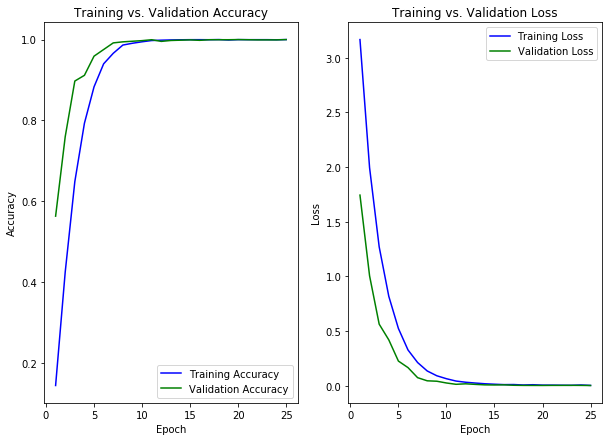

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize = (10, 7))

plt.subplot(1,2,1)
plt.plot(epochs, acc, c = 'b', label = 'Training Accuracy')
plt.plot(epochs, val_acc, c = 'g', label = 'Validation Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss, c = 'b', label = 'Training Loss')
plt.plot(epochs, val_loss, c = 'g', label = 'Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Evaluate model on test set

In [ ]:
eval_loss, eval_acc = model.evaluate(X_test, Y_test)
print('Evaluation Loss: {:.4f}, Evaluation Accuracy: {:.2f}'.format(eval_loss, eval_acc * 100))

2679/2679 [==============================] - 1s 471us/step
Evaluation Loss: 0.0009, Evaluation Accuracy: 100.00


### Make predictions

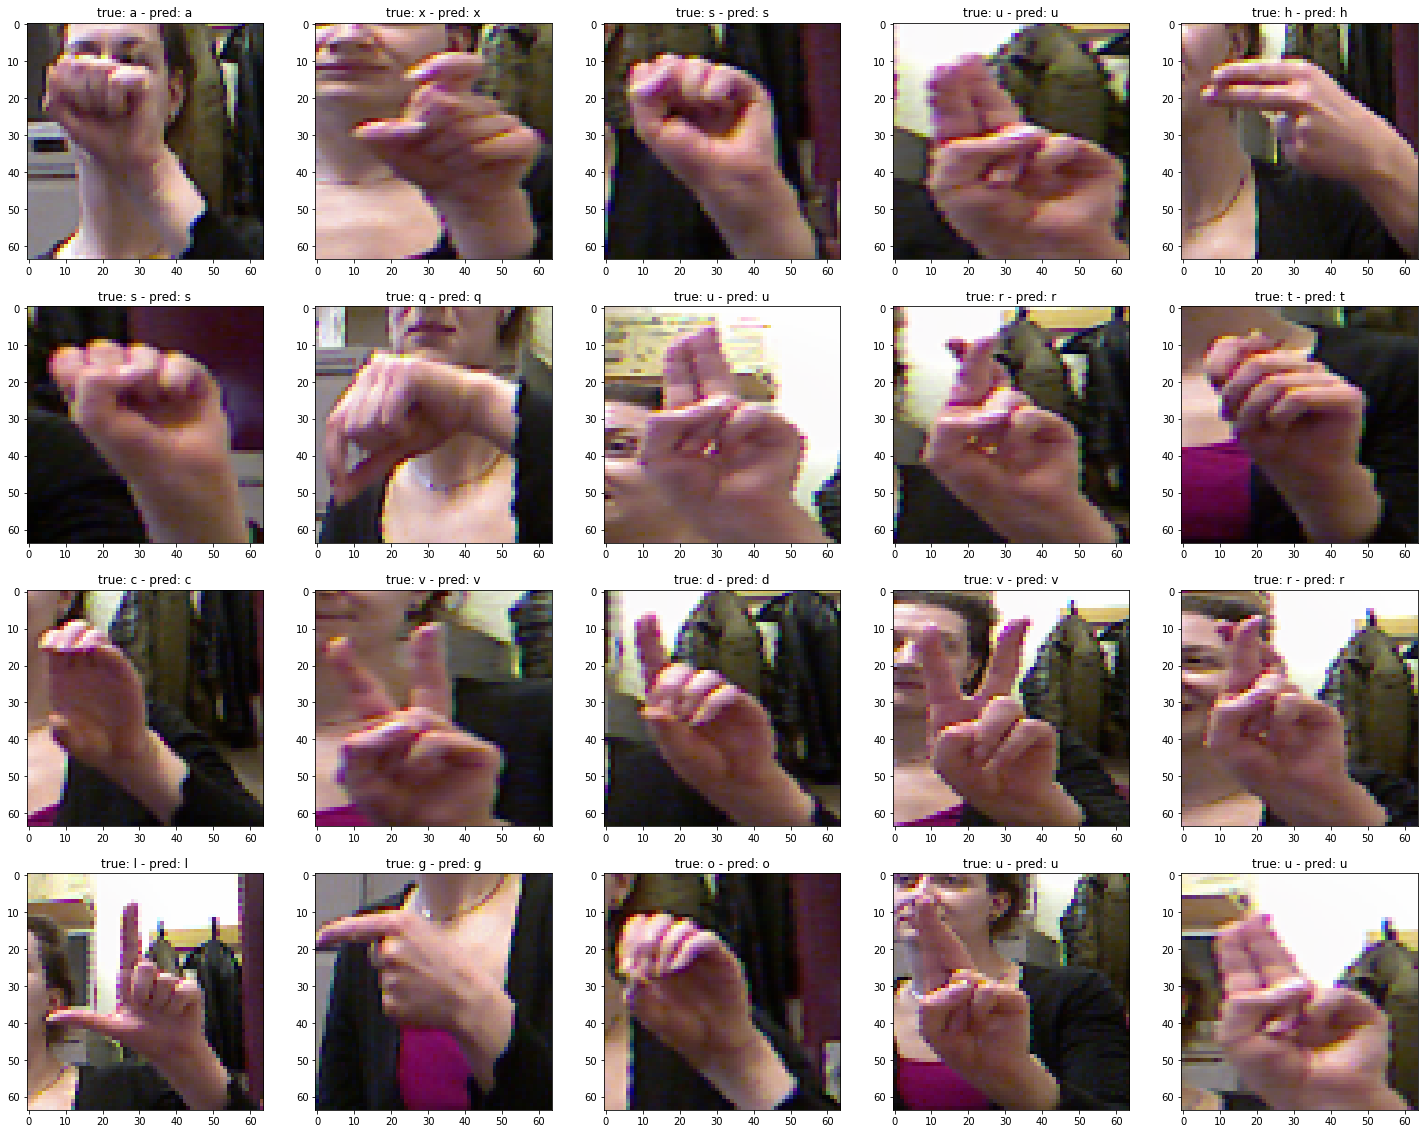

In [ ]:
preds = model.predict(X_test)

plt.figure(figsize = (25,20))
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.imshow(X_test[i])
    plt.title('true: {} - pred: {}'.format(lbl_binarizer.classes_[np.argmax(Y_test[i], axis = -1)], lbl_binarizer.classes_[np.argmax(preds[i], axis = -1)]))
    
plt.show()

### Test with custom images

In [ ]:
custom_images_path = '../input/custom-images/'

def prepare_custom_images(filepath, height = 64, width = 64):
    images = []
    for file in os.listdir(filepath):
        img = cv2.imread(os.path.join(filepath,file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (height, width))
        img = img / 255.
        images.append(img)
    
    return np.array(images)

custom_images = prepare_custom_images(custom_images_path)

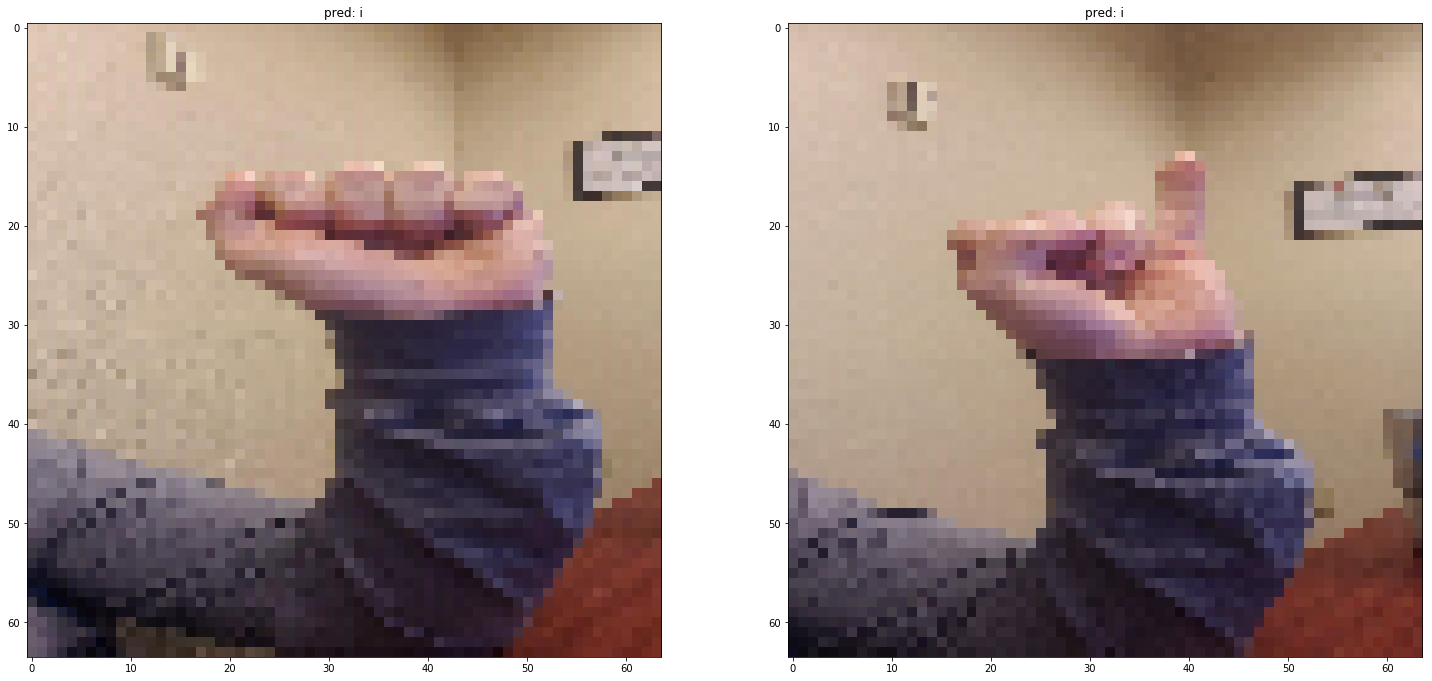

In [ ]:
custom_preds = model.predict(custom_images)

plt.figure(figsize = (25,20))
for i in range(len(custom_preds)):
    plt.subplot(1,2,i+1)
    plt.imshow(custom_images[i])
    plt.title('pred: {}'.format(lbl_binarizer.classes_[np.argmax(custom_preds[i], axis = -1)]))
    
plt.show()

### Save model

In [ ]:
model_path = 'models'
if not os.path.isdir(model_path): os.mkdir(model_path)

model.save('models/my_model.h5')